# Stance Detection

In [2]:
import sys
sys.path.insert(0, './preprocessing/')
import torch
import pandas as pd
import nltk
import numpy as np
import preprocessing.main
import preprocessing.helpers
import preprocessing.utils
import preprocessing.feature_engineering
import preprocessing.word_embeddings
import importlib
from collections import Counter
from sklearn.metrics import confusion_matrix
import score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import time
import itertools
import utils

In [3]:
#preprocess.extract_word_embeddings("glove.6B.50d")

In [4]:
importlib.reload(preprocessing.main)
importlib.reload(preprocessing.utils)
importlib.reload(preprocessing.helpers)
importlib.reload(preprocessing.feature_engineering)
importlib.reload(preprocessing.word_embeddings)
preprocess = preprocessing.main.Preprocessing()

In [5]:
train_stances = pd.read_csv("fn_data/train_stances.csv")
train_stances = train_stances.loc[lambda x: x.Stance != "unrelated"]
print(train_stances.shape)
train_stances.head()

(13427, 3)


,Headline,Body ID,Stance
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
4,Spider burrowed through tourist's stomach and ...,1923,disagree
5,'Nasa Confirms Earth Will Experience 6 Days of...,154,agree
8,Banksy 'Arrested & Real Identity Revealed' Is ...,1739,agree
10,Gateway Pundit,2327,discuss


In [6]:
train_bodies = pd.read_csv("fn_data/train_bodies.csv")
print(train_bodies.shape)
train_bodies.head()

(1683, 2)


,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [7]:
stances_tr, stances_val = preprocess.train_test_split(train_bodies, train_stances)
stances_tr.shape, stances_val.shape

((10775, 3), (2652, 3))

In [8]:
ct = Counter(stances_val['Stance'])
print(ct)
print(ct.most_common(1)[0][1]/len(list(stances_val["Stance"])))

Counter({'discuss': 1835, 'agree': 672, 'disagree': 145})
0.6919306184012066


In [9]:
glove_dict = preprocess.get_glove_dict("glove.6B.50d")

In [10]:
[(nltk.pos_tag([x]),preprocess.get_sentiment(x)) for x in preprocess.get_clean_tokens(list(stances_tr.iloc[2,:])[0], False)]

[([('nasa', 'NN')], {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}),
 ([('confirms', 'NNS')],
  {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}),
 ([('earth', 'NN')], {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}),
 ([('experience', 'NN')],
  {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}),
 ([('day', 'NN')], {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}),
 ([('total', 'JJ')], {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}),
 ([('darkness', 'NN')],
  {'compound': -0.25, 'neg': 1.0, 'neu': 0.0, 'pos': 0.0}),
 ([('december', 'NN')], {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}),
 ([('fake', 'NN')], {'compound': -0.4767, 'neg': 1.0, 'neu': 0.0, 'pos': 0.0}),
 ([('news', 'NN')], {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}),
 ([('story', 'NN')], {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}),
 ([('go', 'VB')], {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}),
 ([('viral', 'JJ')], {'compound': 0.0, 'neg': 0.0, 'neu':

In [11]:
preprocess.cosine_similarity(glove_dict['reveal'], glove_dict['revealed'])

0.7902431610341372

In [12]:
def process_word_stance(word, glove_dict):
    #50d word vector
    if word in glove_dict:
        wv = glove_dict[word]
    else:
        wv = np.zeros((50, ))
    #4d sentiment
    sent = preprocess.get_sentiment(word)
    #16d one-hot encoding of part of speech (shortened)
    pos = nltk.pos_tag(word)[1][0]
    pos_encoding = [(1 if tag == pos else 0) for tag in preprocess.pos_short]
    #boolean flag for negating word
    stemmed_word = preprocess.stem_word(word)
    is_neg = (1 if stemmed_word in preprocess.negating_words_stemmed else 0)
    is_refuting = (1 if stemmed_word in preprocess.refuting_words_stemmed else 0)
    embedding = np.concatenate([wv, [sent["pos"], sent["neg"], sent["neu"], sent["compound"], is_neg, is_refuting], pos_encoding])
    return embedding

def process_text_stance(text, glove_dict, n_words = 20):
    tokens = preprocess.get_clean_tokens(text, False)
    if len(tokens)>=n_words:
        tokens = tokens[:n_words]
        encoding = np.array([process_word_stance(token, glove_dict) for token in tokens])
    elif len(tokens)<n_words:
        padding = [np.zeros((72,))]*(n_words-len(tokens))
        encoding = np.array([process_word_stance(token, glove_dict) for token in tokens]+padding)
    return encoding

def process_bodies_stance(df, glove_dict):
    body_info = {}
    ids = list(df["Body ID"])
    for i in range(len(ids)):
        if i % 100 == 0 and i != 0:
            print("processed "+str(i))
        body_info[ids[i]] = process_text_stance(preprocess.get_body(ids[i],df), glove_dict, 40)
    print("done! processed " + str(len(ids)))
    return body_info

def process_feats_stance(data, body_dict, glove_dict):
    headline, body_id = data[0], int(data[1])
    padding = [np.zeros((72,))]*(10)
    return np.concatenate([process_text_stance(headline, glove_dict), np.array(padding), body_dict[body_id]])

In [13]:
body_dict = process_bodies_stance(train_bodies, glove_dict)

processed 100
processed 200
processed 300
processed 400
processed 500
processed 600
processed 700
processed 800
processed 900
processed 1000
processed 1100
processed 1200
processed 1300
processed 1400
processed 1500
processed 1600
done! processed 1683


In [14]:
start = time.time()
train_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_tr.values]
val_feats = [process_feats_stance(i, body_dict, glove_dict) for i in stances_val.values]
end = time.time()
print(int(end-start))

71


In [ ]:
train_feats.shape

In [40]:
def get_batch(data, targets, i,batch_size):
    batches = data[i*batch_size:i*batch_size+batch_size]
    results = targets[i*batch_size:i*batch_size+batch_size]
    results = [(2.0 if result == "agree" else (1.0 if result == "discuss" else 0.0)) for result in results]
    batches = np.array(batches)
    return np.swapaxes(batches, 0, 1),np.array(results)

In [41]:
# Test the Model
def eval_model(model):
    correct = 0
    total = 0
    batch_x_test,batch_y_test = get_batch(val_feats,[str(x[-1]) for x in stances_val.values],0,len(stances_val))
    model.eval()
    predicted = None
    with torch.no_grad():
        inputs = Variable(torch.FloatTensor(batch_x_test))
        labels = torch.LongTensor(batch_y_test)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy: %d %%' % (100 * correct / total))
    return predicted

In [42]:
def score_model(predictions):    
    #use FNC scorer to generate score report
    label_prediction = [("agree" if x == 2 else ("discuss" if x == 1 else "disagree")) for x in predictions]
    label_actual = pd.DataFrame(stances_val)['Stance']
    matrix = confusion_matrix(label_actual,label_prediction)
    print('confusion matrix: \n{}\n'.format(matrix))
    score.report_score(label_actual, label_prediction)
    return matrix

In [71]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [82]:
# LSTM
class RNN_LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [sent len, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(x)
        
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
                
        #hidden = [batch size, hid dim * num directions]
            
        fc = self.fc(hidden.squeeze(0))
        return fc

In [ ]:
# GRU
class RNN_GRU(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [sent len, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(x)
        
        #output = [sent len, batch size, hid dim * num directions]
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
                
        #hidden = [batch size, hid dim * num directions]
            
        fc = self.fc(hidden.squeeze(0))
        return fc

In [83]:
num_epochs = 10
batch_size = 250
display_step = 1

EMBEDDING_DIM = 72
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

In [90]:
model = RNN_LSTM(EMBEDDING_DIM, 128, OUTPUT_DIM, N_LAYERS-1, BIDIRECTIONAL, DROPOUT)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

model2 = RNN_LSTM(EMBEDDING_DIM, 256, OUTPUT_DIM, N_LAYERS-1, BIDIRECTIONAL, DROPOUT)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-4, weight_decay=1e-5)

model3 = RNN_GRU(EMBEDDING_DIM, 128, OUTPUT_DIM, N_LAYERS-1, BIDIRECTIONAL, DROPOUT)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-4, weight_decay=1e-5)

model4 = RNN_GRU(EMBEDDING_DIM, 256, OUTPUT_DIM, N_LAYERS-1, BIDIRECTIONAL, DROPOUT)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=1e-4, weight_decay=1e-5)

criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()

/Users/dannyyang/anaconda3/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
queue = [(model,optimizer),(model2,optimizer2),(model3,optimizer3),(model4,optimizer4)]

In [91]:
def train(model, total_batch, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train_feats, [str(x[-1]) for x in stances_tr.values],i,batch_size)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

def evaluate(model, total_batch, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for i in range(total_batch):
            batch_x,batch_y = get_batch(val_feats, [str(x[-1]) for x in stances_val.values],i,batch_size)
            inputs = Variable(torch.FloatTensor(batch_x))
            labels = Variable(torch.LongTensor(batch_y))
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            _, predicted = torch.max(predictions.data, 1)
            acc = binary_accuracy(predicted, labels)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [92]:
batches_train= int(len(train_feats)/batch_size)
batches_val = int(len(val_feats)/batch_size)

for x in queue:
    model = x[0]
    optimizer = x[1]
    print(f'model {}')
    for epoch in range(num_epochs):

        train_loss, train_acc = train(model, batches_train, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, batches_val, criterion)

        print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 1.004 | Train Acc: 63.30% | Val. Loss: 0.906 | Val. Acc: 68.16% |
| Epoch: 02 | Train Loss: 0.851 | Train Acc: 65.85% | Val. Loss: 0.748 | Val. Acc: 68.16% |
| Epoch: 03 | Train Loss: 0.783 | Train Acc: 65.87% | Val. Loss: 0.720 | Val. Acc: 68.16% |
| Epoch: 04 | Train Loss: 0.761 | Train Acc: 65.93% | Val. Loss: 0.688 | Val. Acc: 68.48% |
| Epoch: 05 | Train Loss: 0.738 | Train Acc: 67.14% | Val. Loss: 0.669 | Val. Acc: 70.04% |
| Epoch: 06 | Train Loss: 0.725 | Train Acc: 68.58% | Val. Loss: 0.659 | Val. Acc: 71.56% |
| Epoch: 07 | Train Loss: 0.714 | Train Acc: 69.39% | Val. Loss: 0.650 | Val. Acc: 72.72% |
| Epoch: 08 | Train Loss: 0.705 | Train Acc: 70.05% | Val. Loss: 0.643 | Val. Acc: 73.88% |
| Epoch: 01 | Train Loss: 0.959 | Train Acc: 63.95% | Val. Loss: 0.792 | Val. Acc: 68.16% |
| Epoch: 02 | Train Loss: 0.789 | Train Acc: 65.85% | Val. Loss: 0.715 | Val. Acc: 68.16% |
| Epoch: 03 | Train Loss: 0.755 | Train Acc: 65.95% | Val. Loss: 0.680 | Val. Ac

In [77]:
# Test the Model
predicted = eval_model(model)

Accuracy: 71 %


In [78]:
predicted_l = [i.item() for i in list(predicted)]
Counter(predicted_l)

Counter({1: 1952, 2: 682})

confusion matrix: 
[[ 348    0  349]
 [  70    0   67]
 [ 264    0 1536]]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    348    |     0     |    349    |     0     |
-------------------------------------------------------------
| disagree  |    70     |     0     |    67     |     0     |
-------------------------------------------------------------
|  discuss  |    264    |     0     |   1536    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2071.5 out of 2634.0	(78.64464692482916%)
Normalized confusion matrix
[[0.49928264 0.         0.50071736]
 [0.51094891 0.         0.48905109]
 [0.14666667 0.         0.85333333]]


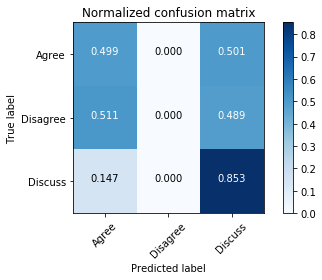

In [79]:
matrix = score_model(predicted_l)
utils.plot_confusion_matrix(matrix, classes=["Agree","Disagree", "Discuss"],
                      title='Normalized confusion matrix')
plt.show()

Accuracy: 72 %
confusion matrix: 
[[ 374    0  323]
 [  72    0   65]
 [ 261    0 1539]]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    374    |     0     |    323    |     0     |
-------------------------------------------------------------
| disagree  |    72     |     0     |    65     |     0     |
-------------------------------------------------------------
|  discuss  |    261    |     0     |   1539    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2093.25 out of 2634.0	(79.47038724373576%)
Normalized confusion matrix
[[0.53658537 0.         0.46341463]
 [0.52554745 0.         0.47445255]
 [0.145      0.         0.855     ]]


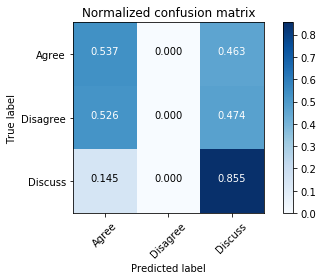

Accuracy: 74 %
confusion matrix: 
[[ 345    0  352]
 [  66    0   71]
 [ 190    0 1610]]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    345    |     0     |    352    |     0     |
-------------------------------------------------------------
| disagree  |    66     |     0     |    71     |     0     |
-------------------------------------------------------------
|  discuss  |    190    |     0     |   1610    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2124.75 out of 2634.0	(80.66628701594533%)
Normalized confusion matrix
[[0.49497848 0.         0.50502152]
 [0.48175182 0.         0.51824818]
 [0.10555556 0.         0.89444444]]


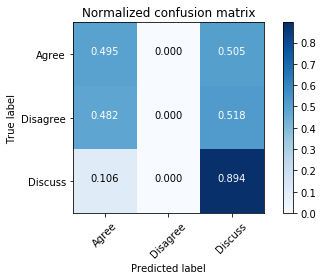

Accuracy: 71 %
confusion matrix: 
[[ 351    0  346]
 [  63    0   74]
 [ 273    0 1527]]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    351    |     0     |    346    |     0     |
-------------------------------------------------------------
| disagree  |    63     |     0     |    74     |     0     |
-------------------------------------------------------------
|  discuss  |    273    |     0     |   1527    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2067.0 out of 2634.0	(78.4738041002278%)
Normalized confusion matrix
[[0.5035868  0.         0.4964132 ]
 [0.45985401 0.         0.54014599]
 [0.15166667 0.         0.84833333]]


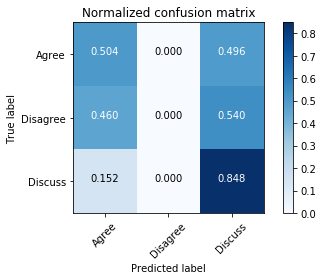

Accuracy: 72 %
confusion matrix: 
[[ 365    0  332]
 [  71    0   66]
 [ 266    0 1534]]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    365    |     0     |    332    |     0     |
-------------------------------------------------------------
| disagree  |    71     |     0     |    66     |     0     |
-------------------------------------------------------------
|  discuss  |    266    |     0     |   1534    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2082.75 out of 2634.0	(79.07175398633258%)
Normalized confusion matrix
[[0.52367288 0.         0.47632712]
 [0.51824818 0.         0.48175182]
 [0.14777778 0.         0.85222222]]


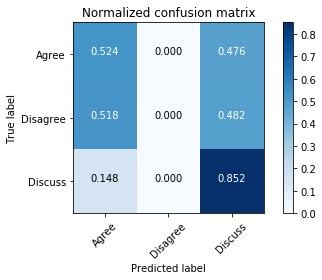

Accuracy: 72 %
confusion matrix: 
[[ 374    0  323]
 [  72    0   65]
 [ 261    0 1539]]

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    374    |     0     |    323    |     0     |
-------------------------------------------------------------
| disagree  |    72     |     0     |    65     |     0     |
-------------------------------------------------------------
|  discuss  |    261    |     0     |   1539    |     0     |
-------------------------------------------------------------
| unrelated |     0     |     0     |     0     |     0     |
-------------------------------------------------------------
Score: 2093.25 out of 2634.0	(79.47038724373576%)
Normalized confusion matrix
[[0.53658537 0.         0.46341463]
 [0.52554745 0.         0.47445255]
 [0.145      0.         0.855     ]]


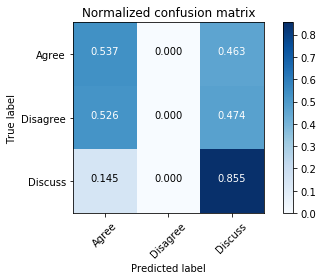

In [93]:
for model in [model, model2, model3, model4, model5]:
    predicted = eval_model(model)
    predicted_l = [i.item() for i in list(predicted)]
    matrix = score_model(predicted_l)
    utils.plot_confusion_matrix(matrix, classes=["Agree","Disagree", "Discuss"],
                      title='Normalized confusion matrix')
    plt.show()

In [ ]:
true_label = [(2 if x[-1] == "agree" else (1 if x[-1] == "discuss" else 0)) for x in stances_val.values]
[list(x) for x in list(confusion_matrix(true_label,predicted_l))]

In [94]:
torch.save(model2.state_dict(), './saved_models/LSTM_1_256.pth')

# train finalized model below

In [ ]:
model_final = CNN(EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [ ]:
fts = train_feats+val_feats
tr_labels = [str(x[-1]) for x in stances_tr.values]+[str(x[-1]) for x in stances_val.values]

def train_final(model, total_batch, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model_final.train()
    for i in range(total_batch):
        batch_x,batch_y = get_batch(fts, tr_labels,i,batch_size)
        inputs = Variable(torch.FloatTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        
        optimizer.zero_grad()
        predictions = model_final(inputs)
        loss = criterion(predictions, labels)
        _, predicted = torch.max(predictions.data, 1)
        acc = binary_accuracy(predicted, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / total_batch, epoch_acc / total_batch

In [ ]:
batches_train= int(len(fts)/batch_size)

for epoch in range(num_epochs):
    train_loss, train_acc = train_final(model_f, batches_train, optimizer, criterion)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |')

In [ ]:
torch.save(model_final.state_dict(), './CNN_model_softmax_final.pth')